## Chloropleth for SICRU model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import numpy as np

import matplotlib

In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

# EDIT THIS --> get table and add last week fields

In [3]:
##CHANGE THIS TO THE LAST DATE OF THE DATASET
##REPLACE MAY 7TH WITH THE CORRECT DATA NAME

def add_latestwk(df, stats):
    for stat in stats:
        df['%s (May 21st)' % stat] = df.filter(regex=("%s \(w.*" % stat)).apply(lambda x: x.dropna().get(-1, None), axis=1)
    return df


tbpath = "/Users/aavattikutis/Box/covid-19_share/fit10tablesnew/"
df = pd.read_csv(tbpath + "fit_table_reweighted.csv") 

df = add_latestwk(df, ['Rt', 'car', 'ifr'])

productpath = "../../results/"

### get rois

In [4]:
rois = list(df.roi.unique())
rois = list(set(rois))

roi_us = np.sort([i for i in rois if i[:2]=='US'])[::-1]
roi_other = np.sort([i for i in rois if i[:2]!='US'])[::-1]
rois = list(roi_us) + list(roi_other)



In [5]:
# 'Sudan' in rois

### make roi dictionaries for cartopy, natural earth

In [6]:
statehash = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [7]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

#get list of all namr type fields

ct = next(countries)

names_ = [i for i in ct.attributes.keys() if 'NAME' in i]

# print(names_)

# ct1_ = [ct.attributes['NAME_LONG'] for ct in countries]
# countries = reader.records()
# ct2_ = [ct.attributes['NAME'] for ct in countries]
# countries = reader.records()
# ct3_ = [ct.attributes['NAME_ALT'] for ct in countries]
# countries = reader.records()
# for ct in countries:
#     print(ct.attributes['NAME_ALT'])

# print(country.attributes.keys())   
    
# ct_=np.sort(ct_)
    
roi2ct = {}
# for roi in roi_other:
#     for ct in ct_:
# #         print(ct)
#         if roi == ct:
#             roi2ct[roi] = ct
#             break
#         else
            
roi2ct['Burma'] = 'Myanmar'
roi2ct['Korea, South'] = 'Republic of Korea' 
roi2ct['Czechia'] = 'Czech Republic'
roi2ct['North Macedonia'] = 'Macedonia'
roi2ct['Congo (Brazzaville)'] = 'Republic of the Congo'
roi2ct['Congo (Kinshasa)'] = 'Democratic Republic of the Congo'
roi2ct['Taiwan*'] = 'Taiwan'

ct2roi = {v: k for k, v in roi2ct.items()}

### define geoplot function

In [8]:

def geoplot(thetaroot,thetabool,sc,ax,title,cmap,maptype):

#     ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#     ax.add_feature(cartopy.feature.LAKES, color='b',alpha=0.01)
#     ax.add_feature(cartopy.feature.RIVERS)
    # ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    
    
    reader_ct = shpreader.Reader(shpfilename)
    
    shpfilename_us = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_1_states_provinces_lakes_shp')
    reader_us = shpreader.Reader(shpfilename_us)
    ctmapped_ = []
    usmapped_ = []
    for roi in roi_other:
        try:
            #find the ct element
            countries = reader_ct.records()
            for cttest in countries:
                for name in names_:
                    if roi == cttest.attributes[name]:
                        ct = cttest
            if roi in roi2ct.keys():
                countries = reader_ct.records()
                for cttest in countries:
                    if roi2ct[roi] == cttest.attributes['NAME_LONG']:
                        ct = cttest
            if thetabool == 0:
                c = sc*df.loc[(df.roi==roi)&(df['quantile']=='0.5'), thetaroot].values[0]
            else:
                c = sc*df.loc[(df.roi==roi)&(df['quantile']=='0.5'), thetaroot + ' (May 21st)'].values[0]
            if ct.geometry.type == 'Polygon':
                ct_geo = [ct.geometry]
            else:
                ct_geo = ct.geometry
            ax.add_geometries(ct_geo, maptype, facecolor=cmap(c))
            ctmapped_.append(ct.attributes['NAME_LONG'])
            del(ct)
        except:
            print(roi)
            pass
            
            
    countries = reader_ct.records()
    for ct in countries:
        if (ct.attributes['NAME_LONG'] in ctmapped_)==False:
            if ct.geometry.type == 'Polygon':
                ct_geo = [ct.geometry]
            else:
                ct_geo = ct.geometry
            ax.add_geometries(ct_geo, maptype, facecolor='gray')

    for roi in roi_us:
        try:
        #find the ct element
            states = reader_us.records()
            for sttest in states:
                if roi.split('_')[1] == (sttest.attributes['name_alt']).split("|")[0]:
                    st = sttest
                elif len((sttest.attributes['name_alt']).split("|"))>1:
                    if roi.split('_')[1] == (sttest.attributes['name_alt']).split("|")[1]:
                        st = sttest
    #             if roi in roi2ct.keys():
    #                 countries = reader_ct.records()
    #                 for cttest in countries:
    #                     if roi2ct[roi] == cttest.attributes['NAME_LONG']:
    #                         ct = cttest
            if thetabool == 0:
                c = sc*df.loc[(df.roi==roi)&(df['quantile']=='0.5'), thetaroot].values[0]
            else:
                c = sc*df.loc[(df.roi==roi)&(df['quantile']=='0.5'), thetaroot + ' (May 21st)'].values[0]
            if st.geometry.type == 'Polygon':
                st_geo = [st.geometry]
            else:
                st_geo = st.geometry
            ax.add_geometries(st_geo, maptype, facecolor=cmap(c))
            usmapped_.append(st.attributes['name_alt'])
            del(st)
        except:
            print(roi)
            pass
    states = reader_us.records()
    for st in states:
        if (st.attributes['name_alt'] in usmapped_)==False:
#             print(st.attributes['name_alt'])
            if st.geometry.type == 'Polygon':
                st_geo = [st.geometry]
            else:
                st_geo = st.geometry
            ax.add_geometries(st_geo, maptype, facecolor='gray')
    ax.set_title(title+'\n(color scale 0-'+str(1./sc)+', gray=missing data)')
    return 

In [17]:
theta = 'ifr' #options are: R, car, ifr

West Bank and Gaza
Singapore
Seychelles
Sao Tome and Principe
San Marino
Saint Vincent and the Grenadines
Saint Lucia
Saint Kitts and Nevis
Monaco
Mauritius
Malta
Maldives
MS Zaandam
Liechtenstein
Holy See
Grenada
Eswatini
Dominica
Diamond Princess
Comoros
Cabo Verde
Barbados
Bahrain
Antigua and Barbuda
Andorra
AA_Global
US_VI
US_PR
US_MP
US_GU
US
West Bank and Gaza
Singapore
Seychelles
Sao Tome and Principe
San Marino
Saint Vincent and the Grenadines
Saint Lucia
Saint Kitts and Nevis
Monaco
Mauritius
Malta
Maldives
MS Zaandam
Liechtenstein
Holy See
Grenada
Eswatini
Dominica
Diamond Princess
Comoros
Cabo Verde
Barbados
Bahrain
Antigua and Barbuda
Andorra
AA_Global
US_VI
US_PR
US_MP
US_GU
US


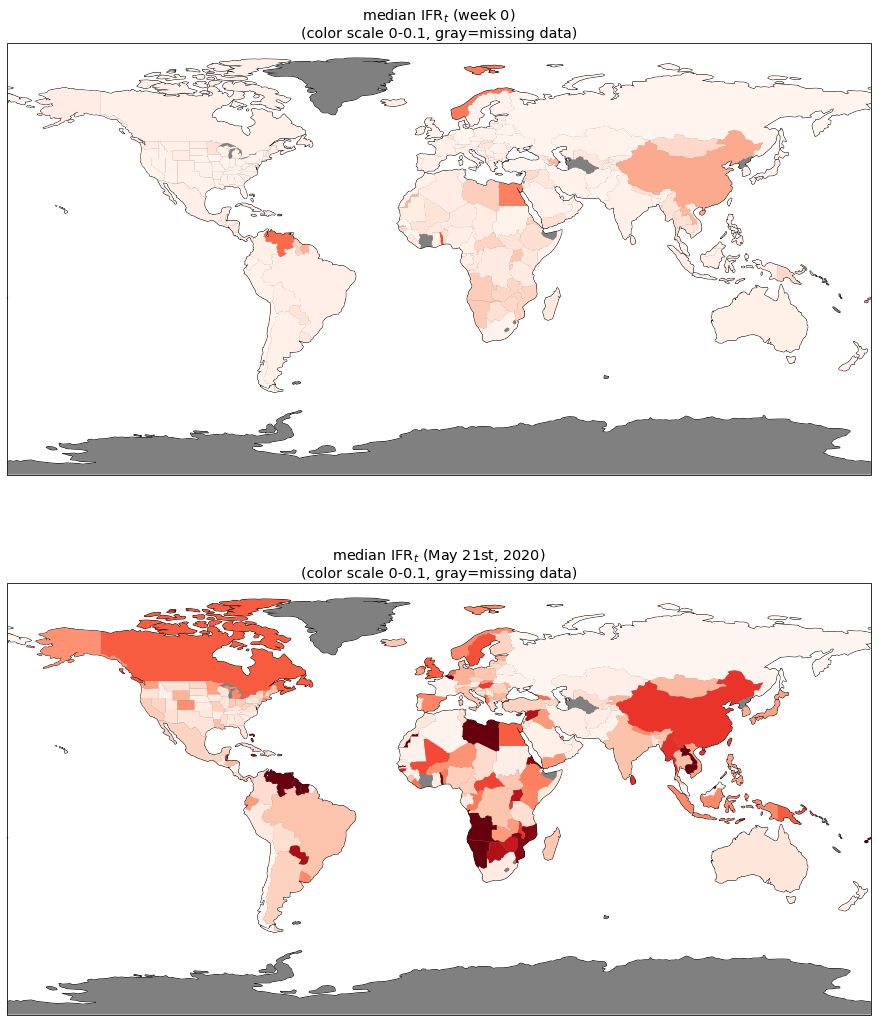

In [18]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

import cartopy.crs as ccrs
maptype = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, subplot_kw=dict(projection=maptype),figsize=(15,15))



if theta == 'R':
    sc = 0.2
    cmap = matplotlib.cm.get_cmap('Purples')
    geoplot('R0',0,sc,ax[0],r'median R0',cmap,maptype)
    geoplot('Rt',1,sc,ax[1],r'median R$_t$ (May 21st, 2020)',cmap,maptype)
    plt.subplots_adjust(left=-0.05,right=1.05,top=0.95, hspace = 0.25,bottom=0.05)
    plt.savefig(productpath+'Rtgeo.png', dpi=200)

if theta == 'car':
    sc = 2
    cmap = matplotlib.cm.get_cmap('Greens')
    geoplot('car (week 0)',0,sc,ax[0],r'median CAR$_t$ (week 0)',cmap,maptype)
    geoplot('car',1,sc,ax[1],r'median CAR$_t$ (May 21st, 2020)',cmap,maptype)
    plt.subplots_adjust(left=-0.05,right=1.05,top=0.95, hspace = 0.25,bottom=0.05)
    plt.savefig(productpath+'CARtgeo.png', dpi=200)
if theta == 'ifr':
    sc=10
    cmap = matplotlib.cm.get_cmap('Reds')
    geoplot('ifr (week 0)',0,sc,ax[0],r'median IFR$_t$ (week 0)',cmap,maptype)
    geoplot('ifr',1,sc,ax[1],r'median IFR$_t$ (May 21st, 2020)',cmap,maptype)
    plt.subplots_adjust(left=-0.05,right=1.05,top=0.95, hspace = 0.25,bottom=0.05)
    plt.savefig(productpath+'IFRtgeo.png', dpi=200)    




